# Testing Adaptive Learning with Simulations

## Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from __future__ import division # Ensures that a/b is always a float.
from IPython.display import display, clear_output

import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m
import abc
import datetime
from time import sleep
from adaptive import *
import topchef_client

## Setup

Connect to the server that sends experiments to the lab.

In [2]:
server_url = 'http://129.97.136.203:5001'
service_id = 'c8b1b068-aefc-43db-992c-d9dafaaac59a'
client = topchef_client.Client(server_url)
service = client.services[service_id]

Connect to the parallel engines of this computer.

In [3]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

## Initialize Prior and Sweeps

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")
 - wo: Carrier offset from 2870MHz, positive or negative (MHz)

In [5]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.25])
target_stds = np.array([0.01,0.005,0.01,0.005,0.01])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)
medium_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    10*target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

drift_prior = qi.UniformDistribution(
    [[0.008,0.0012],[0.002,0.005],[0,0.0001],[0,0.0001],[0,0.00001]]
)

In [6]:
ham_model = m.RabiRamseyModel()
ref_model = m.ReferencedPoissonModel(ham_model)

## Test Experiment Runners

Here is a simulation based experiment runner:

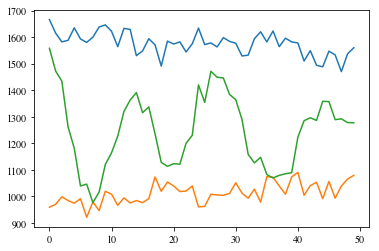

In [7]:
sim = SimulatedRabiRamseyExperimentRunner(true_value)
rabi_eps = rabi_sweep(max_t=0.3,n=50,n_meas=100000)
results = np.empty((rabi_eps.size, 3))
for idx, eps in enumerate(rabi_eps):
    job = sim.run_experiment(np.atleast_1d(eps))
    while not job.is_complete:
        sleep(0.01)
    results[idx, :] = job.get_result().triplet
plt.plot(results)

Now the same thing with real data:

sim = RealRabiRamseyExperimentRunner(service)
rabi_eps = rabi_sweep(max_t=0.3,n=2,n_meas=100000)
results = np.empty((rabi_eps.size, 3))
for idx, eps in enumerate(rabi_eps):
    job = sim.run_experiment(np.atleast_1d(eps))
    while not job.is_complete:
        sleep(0.5)
    results[idx, :] = job.get_result().triplet
plt.plot(results)

## Heuristic Testing with Experimental Data

In [8]:
experiment = RealRabiRamseyExperimentRunner(service)

In [9]:
def make_updater():
    model = qi.DirectViewParallelizedModel(
        qi.GaussianRandomWalkModel(
            m.ReferencedPoissonModel(m.RabiRamseyModel()),
            random_walk_idxs=[5,6],
            diagonal=False,
            scale_mult=experiment_time
        ), 
        dview, 
        serial_threshold=1
    )
    return qi.SMCUpdater(model, 10000, qi.ProductDistribution(wide_prior, drift_prior))

In [10]:
n_meas = 100000

### Linear Heuristic

In [11]:
n_trials = 2
n_eps = 4

panel_linear = HeuristicData('../data/linear_heuristic.pkl')

def make_heuristic():
    return TrackingHeuristic(
        LinearHeuristic(make_updater(), max_t=0.3, max_tau=2, n=int(n_eps/2), n_meas=n_meas),
        cutoff=0.85,
        track_on_initial_reference=True,
        std_mult=3
    )

for idx_trial in range(panel_linear.n_dataframes, n_trials):
    # construct heuristic and data storage container for this run
    heuristic = make_heuristic()
    df = new_experiment_dataframe(heuristic)
    
    # initialize reference prior empirically
    heuristic.take_initial_reference(experiment)
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps-1):
        # print current status
        clear_output()
        print 'Current Trial: {}'.format(idx_trial)
        display(df)
        
        # submit experiment job
        job = experiment.run_experiment(eps, precede_by_tracking)

        # reset the prior on the references if we just instructed a tracking operation
        if precede_by_tracking:
            heuristic.reset_reference_prior()
        
        # decide on next experiment while job is running
        tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
        eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)
            
        # update current state of knowledge
        result = job.get_result()
        eps['mode'] = ref_model.BRIGHT
        bright = heuristic.updater.update(result.bright, eps)
        eps['mode'] = ref_model.DARK
        dark = heuristic.updater.update(result.dark, eps)
        eps['mode'] = ref_model.SIGNAL
        signal = heuristic.updater.update(result.signal, eps)
        
        # store results
        df = append_experiment_data(df, 
                expparam=eps, 
                heuristic=heuristic, 
                job=job,
                heuristic_value=None
            )
        
    # save results in panel
    panel_linear.append(df)
    panel_linear.save()

Current Trial: 1


,expparam,bright,dark,signal,completed_ts,returned_ts,submitted_ts,diff_time,run_time,wall_time,...,preceded_by_tracking,eff_num_bits,cum_eff_num_bits,heuristic,heuristic_value,smc_mean,smc_cov,smc_n_eff_particles,smc_resample_count,n_meas
0,NaN,NaN,NaN,NaN,2017-12-20 13:52:10.830105,2017-12-20 13:52:10.830105,2017-12-20 13:52:10.830105,00:00:00,00:00:00,00:00:00,...,NaN,0,0,Standard Linear Heuristic (with tracking),None,"[5.04288434979, 4.98373363375, 0.0051195660978...","[[8.27152849745, -0.00475877149681, -0.0747599...",10000.000000,0,NaN
1,"[[0.05, 0.5, 0.0, 0.0, 1, 0, 100000]]",1876.0,1692.0,1855.0,2017-12-20 13:52:37.574000,2017-12-20 13:52:43.453086,2017-12-20 13:52:31.384523,00:00:26.743895,00:00:02.825000,00:00:12.068563,...,1.0,2.56536,2.56536,Standard Linear Heuristic (with tracking),None,"[4.49920908611, 5.09565185063, 0.0448462701096...","[[9.9930684816, -0.898928031221, -0.1996964743...",5476.228329,1,[100000]
2,"[[1.0, 0.0, 0.0, 0.0, 0, 0, 100000]]",1808.0,1675.0,1956.0,2017-12-20 13:52:47.034000,2017-12-20 13:52:52.758810,2017-12-20 13:52:45.962812,00:00:09.460000,00:00:02.865000,00:00:06.795998,...,0.0,2.44718,5.01254,Standard Linear Heuristic (with tracking),None,"[1.28262338788, 6.86051132694, 0.108655411647,...","[[1.73147915638, 0.206712749174, -0.1167301646...",10000.000000,3,[100000]


In [46]:
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.
    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/np.sum(sorted_weights)
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def quantile(data, weights, quantile):
    """
    Weighted quantile of an array with respect to the last axis.
    Parameters
    ----------
    data : ndarray
        Input array.
    weights : ndarray
        Array with the weights. It must have the same size of the last 
        axis of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile : float
        The output value.
    """
    # TODO: Allow to specify the axis
    nd = data.ndim
    if nd == 0:
        TypeError("data must have at least one dimension")
    elif nd == 1:
        return quantile_1D(data, weights, quantile)
    elif nd > 1:
        n = data.shape
        imr = data.reshape((np.prod(n[:-1]), n[-1]))
        result = np.apply_along_axis(quantile_1D, -1, imr, weights, quantile)
    return result.reshape(n[:-1])

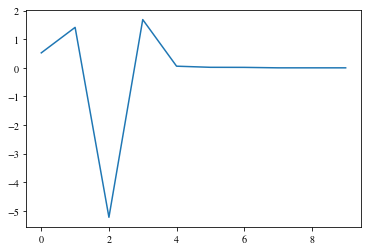

In [47]:
plt.plot(quantile(heuristic.updater.particle_locations.T,heuristic.updater.particle_weights,0.05).T)
plt.plot(quantile(heuristic.updater.particle_locations.T,heuristic.updater.particle_weights,0.05).T)

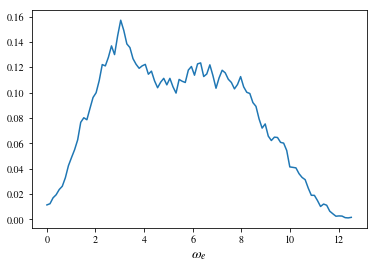

In [25]:
heuristic.updater.plot_posterior_marginal(1)

In [ ]:
eps = linear_heuristic(0.02)
job = experiment.run_experiment(eps, precede_by_tracking=True)
while not job.is_complete:
    sleep(0.5)
df = append_experiment_data(df, expparam=eps, updater=linear_heuristic.updater, job=job)
eps = linear_heuristic(0.02)
job = experiment.run_experiment(eps)
while not job.is_complete:
    sleep(0.5)
df = append_experiment_data(df, expparam=eps, updater=linear_heuristic.updater, job=job)
df

In [46]:
df.eff_num_bits

0                  0
1    [13.3413958037]
2    [13.3413958037]
Name: eff_num_bits, dtype: object

In [26]:
1e-9 * x.astype('float64')

array([   0.      ,    7.820402,   14.567823,  507.382055,  535.64193 ,
        543.64116 ])

## Old

In [ ]:
n_meas = 100000
n_particles = 2000
n_experiments = 100
n_trials = 1

sim = SimulatedRabiRamseyExperimentRunner(true_value)

def make_updater():
    return qi.DirectViewParallelizedModel(
        qi.GaussianRandomWalkModel(
            m.ReferencedPoissonModel(m.RabiRamseyModel()),
            random_walk_idxs=[5,6],
            diagonal=False,
            scale_mult=experiment_time
        ), 
        dview, 
        serial_threshold=1
    )

Q = np.array([1,1,0,0,0])

heuristics = []

track_means = np.zeros((n_trials, n_experiments + 1, 10))
track_covs = np.zeros((n_trials, n_experiments + 1, 10, 10))

for idx_trial in range(n_trials):
    heuristic = RiskHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, qi.ProductDistribution(wide_prior,drift_prior)), 
        Q, 
        rabi_sweep(max_t=0.5, n=50, n_meas=n_meas), 
        ramsey_sweep(max_tau=2, n=50, n_meas=n_meas)
    )
    heuristics.append(heuristic)
    updater = heuristic.updater

    track_means[idx_trial, 0, :] = heuristic.updater.est_mean()
    track_covs[idx_trial, 0, :, :] = heuristic.updater.est_covariance_mtx()

    for idx_eps in range(n_experiments):

        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002

        #decide experiment
        eps = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))

        # simulate outcome
        outcome = sim.run_experiment(eps)

        # update
        eps['mode'] = ref_model.BRIGHT
        bright = updater.update(outcome.bright, eps)
        eps['mode'] = ref_model.DARK
        dark = updater.update(outcome.dark, eps)
        eps['mode'] = ref_model.SIGNAL
        signal = updater.update(outcome.signal, eps)

        # store info
        track_means[idx_trial, idx_eps + 1, :] = updater.est_mean()
        track_covs[idx_trial, idx_eps + 1, :, :] = updater.est_covariance_mtx()

In [ ]:
idx_model = 0
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-wr-variance')

In [ ]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-we-variance')

In [ ]:
idx_model = 3
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-AN-variance')

### Lookahead Heuristic

It would be beneficial to do risk calculations at the same time as experiments, since both tasks are time consuming. The problem, however, is that calculating the best next experiment to do next relies on the latest data, which we would not have if we are doing experiments and calculations concurrently. Three ideas:
 - Scrap concurrency, and just alternate between experiments and next best experiment simulations
 - Choose the next experiment based on the previous posterior, so that one is always slightly out of touch
 - Marginalize the heuristic over the hypothetical outcomes of the currently running experiment

In [ ]:
def lookahead_bayes_risk(updater, first_expparams, second_expparams):
    
    # assume n_out1==n_out2==n_out for convenience
    n_out = updater.model.n_outcomes(np.atleast_1d(first_expparams)[0])
    n_eps1 = first_expparams.size
    n_eps2 = second_expparams.size
    
    # compute all likelihoods
    # the likelihood over outcomes should sum to 1, so don't compute for last outcome for efficiency
    L = updater.model.likelihood(
            np.arange(n_out-1), 
            updater.particle_locations,
            np.concatenate([first_expparams, second_expparams])
        )
    L = np.concatenate([L, (1 - L.sum(axis=0))[np.newaxis, ...]], axis=0).transpose((0,2,1))
    L1 = L[:, :first_expparams.size, :]              # L1.shape == (n_out1, n_eps1, n_particles)
    L2 = L[:, first_expparams.size:, :]              # L1.shape == (n_out2, n_eps2, n_particles)
    
    # compute the hypothetical posterior weights after the first hypothetical experiments, w_hyp1
    # and compute the hypothetical outcome probabilities, N1
    w_hyp1 = L1 * updater.particle_weights[np.newaxis, np.newaxis, :]
    
    # compute the hypothetical posterior weights after all 
    # combinations of first and second expparams and outcomes
    w_hyp12 = w_hyp1[:, np.newaxis, :,  np.newaxis, :] * L2[np.newaxis, :, np.newaxis, :, :]
    N12 = np.sum(w_hyp12, axis=4)                    # N12.shape = (n_out1, n_out2, n_eps1, n_eps2)
    w_hyp12 = w_hyp12 / N12[:, :, :, :, np.newaxis]  # w_hyp12.shape = (n_out1, n_out2, n_eps1, n_eps2, n_particles)

    # compute the hypothetical means and variances given outcomes and exparams
    # mu_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2, n_models)
    # var_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2)
    mu_hyp12 = np.dot(w_hyp12, updater.particle_locations)
    var_hyp12 = np.sum(
        w_hyp12 * 
        np.sum(updater.model.Q * (
            updater.particle_locations[np.newaxis, np.newaxis,np.newaxis,np.newaxis,:,:] - 
            mu_hyp12[:,:,:,:,np.newaxis,:]
        ) ** 2,  axis=5),
        axis=4
    )
    
    # the risk of a given expparam can be calculated as the mean posterior
    # variance weighted over all possible outcomes
    return np.sum(np.sum(N12 * var_hyp12, axis=0), axis=0)

class LookAheadRiskHeuristic(qi.Heuristic):
    def __init__(self, updater, Q, rabi_eps, ramsey_eps, name=None):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._ham_model._Q = Q
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Look-Ahead Bayes Risk, Q={}".format(Q) if name is None else name
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, current_eps, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        risk = lookahead_bayes_risk(self._risk_taker, current_eps, all_eps)[0,:]
        self.risk_history += [risk]
        best_idx = np.argmin(risk, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps

In [ ]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 lookahead_bayes_risk(updater, rabi_eps[4,np.newaxis], rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)

In [ ]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
lbr = lookahead_bayes_risk(updater, rabi_eps, rabi_eps)
fig = plt.figure()
plt.imshow(lbr, extent=[np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau']),np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau'])])
plt.title('Look-ahead Bayes Risk for \nback-to-back Ramsey Experiments')
plt.xlabel('Ramsey #1 t $(\mu s)$')
plt.ylabel('Ramsey #2 t $(\mu s)$')
export_figure(fig, 'risk-look-ahead')

In [ ]:
n_bin = 10
n_particles = 2000
n_experiments = 100
n_trials = 50

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Q = np.array([1,1,0,0,0])
n_updaters=3

heuristics_hal = []

track_means_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5))
track_covs_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5, 5))

for idx_trial in range(n_trials):
    print "Starting Trial {}".format(idx_trial)
    print "================="
    
    heuristics_hal.append([])
    heuristics_hal[-1] = [
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Alternating    '
        ),
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Old Information'
        ),
        LookAheadRiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Look-Ahead     '
        ),
    ]
    
    for idx_h, h in enumerate(heuristics_hal[-1]):
        track_means_lah[idx_trial,idx_h, 0, :] = h.updater.est_mean()
        track_covs_lah[idx_trial,idx_h, 0, :, :] = h.updater.est_covariance_mtx()
        
    # heuristics 1 and 2 require an initial experiment to run
    eps0 = None
    current_est = heuristics_hal[-1][1].updater.est_mean()
    tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
    eps1 = heuristics_hal[-1][1](tp_est)
    eps2 = eps1

    for idx_eps in range(n_experiments):

        #--------------------------------------------------------------------
        # Alternating Heuristic: alternate experiments with risk optimization
        
        idx = 0
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        #decide experiment
        eps0 = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps0[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # simulate outcome
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps0)
        # update
        updater.update(outcome, eps0)
        
        #--------------------------------------------------------------------
        # Old Info Heuristic:    compute risk concurrently, but on the old 
        #                        posterior
        
        idx = 1
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps1)
        # "simultaneously" decide next experiment based on old distribution
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps1_new = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps1_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps1)
        eps1 = eps1_new
        
        #--------------------------------------------------------------------
        # Look-Ahead Heuristic:  Take into account what we expect from the 
        #                        currently running experiment
        
        idx = 2
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps2)
        # "simultaneously" decide next experiment based on old distribution and currently running experiment
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps2_new = heuristic(eps2, tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps2_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps2)
        eps2 = eps2_new
        
        # store info
        for idx_h, h in enumerate(heuristics_hal[-1]):
            track_means_lah[idx_trial,idx_h, idx_eps, :] = h.updater.est_mean()
            track_covs_lah[idx_trial,idx_h, idx_eps, :, :] = h.updater.est_covariance_mtx()
        
        print "---"

In [ ]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(len(heuristics_hal)):
    h = heuristics_hal[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs_lah[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-lah-we-variance')